# **1. Importation des bibliothèques nécessaires**

In [2]:
!pip install mltu
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import tarfile

# **2. Téléchargement et préparation des données**

Chargement des données: 100%|██████████| 115338/115338 [00:00<00:00, 151164.67it/s]


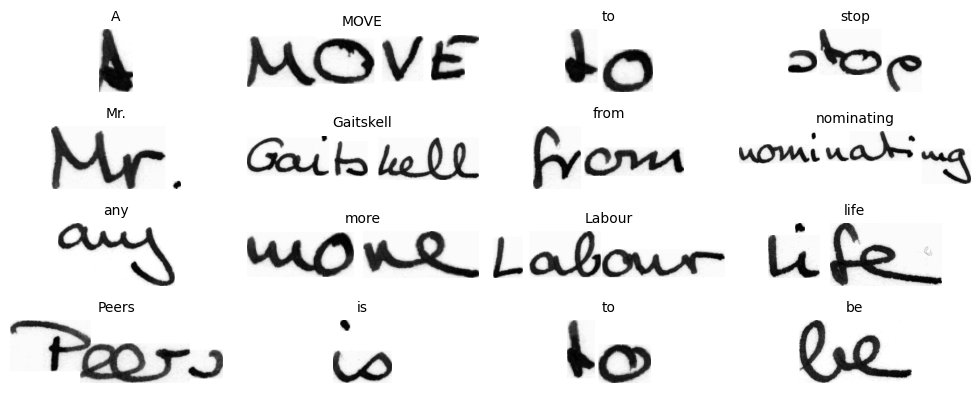

In [3]:
# Fonction pour télécharger et extraire un fichier ZIP
def download_and_unzip(url, extract_to='Datasets', chunk_size=1024 * 1024):
    try:
        http_response = urlopen(url)
        content_length = int(http_response.headers.get('content-length', 0))
        iterations = content_length // chunk_size + 1

        data = b""
        for _ in tqdm(range(iterations), desc="Téléchargement du fichier"):
            chunk = http_response.read(chunk_size)
            if not chunk:
                break
            data += chunk

        zipfile = ZipFile(BytesIO(data))
        zipfile.extractall(path=extract_to)
    except Exception as e:
        print(f"Erreur lors du téléchargement ou de l'extraction : {e}")
        raise

# Préparer le chemin et télécharger les données
dataset_path = os.path.join('Datasets', 'IAM_Words')
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    download_and_unzip('https://git.io/J0fjL', extract_to='Datasets')

    words_tgz_path = os.path.join(dataset_path, "words.tgz")
    if os.path.exists(words_tgz_path):
        with tarfile.open(words_tgz_path, 'r:gz') as tar:
            tar.extractall(path=os.path.join(dataset_path, "words"))

# Chargement des données
dataset = []
vocab = set()
max_len = 0

words_path = os.path.join(dataset_path, "words.txt")
if os.path.exists(words_path):
    with open(words_path, "r") as file:
        words = file.readlines()

    for line in tqdm(words, desc="Chargement des données"):
        if line.startswith("#"):
            continue
        line_split = line.split(" ")
        if line_split[1] == "err":
            continue

        folder1 = line_split[0][:3]
        folder2 = line_split[0][:8]
        file_name = line_split[0] + ".png"
        label = line_split[-1].strip()
        rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)

        if not os.path.exists(rel_path):
            continue

        dataset.append([rel_path, label])
        vocab.update(label)
        max_len = max(max_len, len(label))

# Visualisation des images
def display_images(dataset, num_images=16, columns=4):
    plt.figure(figsize=(10, 5))
    for i, (image_path, label) in enumerate(dataset[:num_images]):
        img = mpimg.imread(image_path)
        plt.subplot(num_images // columns + 1, columns, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(label, fontsize=10)
    plt.tight_layout()
    plt.show()

# Afficher les images
display_images(dataset)

# **3. Prétraitement des images et des étiquettes**

In [15]:
IMG_HEIGHT, IMG_WIDTH = 64, 256
CHARACTERS = sorted(list(vocab))
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
NUM_CLASSES = len(CHARACTERS)

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def encode_label(label):
    return [CHAR_TO_INDEX[char] for char in label]

images, labels = [], []
for image_path, label in tqdm(dataset, desc="Prétraitement des images"):
    try:
        images.append(preprocess_image(image_path))
        labels.append(encode_label(label))
    except Exception as e:
        print(f"Erreur : {image_path} -> {e}")

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=object)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reste du code du modèle inchangé
print(f"Shape des images : {images.shape} (attendu : nombre d'images, {IMG_HEIGHT}, {IMG_WIDTH}, 1)")
print(f"Exemple de label encodé : {y_train[0]} (label brut : {dataset[0][1]})")

Prétraitement des images: 100%|██████████| 21706/21706 [00:12<00:00, 1698.35it/s]


Shape des images : (21706, 64, 256, 1) (attendu : nombre d'images, 64, 256, 1)
Exemple de label encodé : [56, 61] (label brut : A)


# **4. Préparation des labels au format One-Hot**

In [5]:
# Fonction pour convertir les labels en format one-hot
def prepare_labels(labels, max_length, num_classes):
    y = np.zeros((len(labels), max_length, num_classes), dtype=np.float32)
    for i, label in enumerate(labels):
        for t, char_idx in enumerate(label):
            if t < max_length:
                y[i, t, char_idx] = 1.0
    return y

# Trouver la longueur maximale des labels
# max(len(label) for label in labels)
max_label_length = 8

# Préparer les labels pour l'entraînement
y_train_processed = prepare_labels(y_train, max_label_length, NUM_CLASSES)
y_test_processed = prepare_labels(y_test, max_label_length, NUM_CLASSES)


# **5. Construction du modèle avec BiLSTM  --MODELE-2--**

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Bidirectional, LSTM, Reshape, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K


# Définir l'architecture du modèle
input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))  # Image en entrée

# Couches de convolution
x = Conv2D(32, (3, 3), padding="same", activation="relu")(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Redimensionner la sortie des convolutions pour l'entrée LSTM
x = Reshape(target_shape=(int(IMG_HEIGHT / 8), int(IMG_WIDTH / 8) * 128))(x)

# Couches BiLSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.25)(x)

# Décodage final
x = TimeDistributed(Dense(NUM_CLASSES, activation="softmax"))(x)

# Définir le modèle
model = Model(inputs=input_img, outputs=x)

# Compilation du modèle avec CTC Loss
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# **6. Entraînement du modèle --MODELE 2--**

In [14]:
# Callbacks pour l'entraînement
checkpoint = ModelCheckpoint("best_model_2.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    x_train, y_train_processed,
    validation_data=(x_test, y_test_processed),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 256, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 64, 256, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64, 256, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 128, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32, 128, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 16, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 32, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 8, 4096)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 8, 256)              │       4,326,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 8, 74)               │          19,018 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,438,986 (16.93 MB)

 Trainable params: 4,438,538 (16.93 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50


2024-12-09 15:24:56.286733: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1733757896.851941   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.168721   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.170667   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.172354   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.173975   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.214378   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.234562   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757897.255260   22919 gpu_t

  4/543 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.2495 - loss: 3.5674

W0000 00:00:1733757904.569405   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757904.571767   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757904.574538   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757904.578572   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757904.583070   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


542/543 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5555 - loss: 1.7072

W0000 00:00:1733757930.946294   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.947392   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.948676   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.949862   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.951038   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.952262   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.953557   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.954835   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757930.956122   22919 gp

543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5556 - loss: 1.7069

W0000 00:00:1733757931.659444   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.661824   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.663583   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.665678   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.668144   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.670427   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.672996   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.675515   22918 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757931.677747   22918 gp


Epoch 1: val_loss improved from inf to 1.72660, saving model to best_model_2.keras


W0000 00:00:1733757934.733933   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.735022   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.736204   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.737253   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.738314   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.739499   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.740788   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.742116   22919 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733757934.743446   22919 gp

543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.5556 - loss: 1.7065 - val_accuracy: 0.5588 - val_loss: 1.7266
Epoch 2/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6181 - loss: 1.3377
Epoch 2: val_loss improved from 1.72660 to 1.32361, saving model to best_model_2.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.6181 - loss: 1.3377 - val_accuracy: 0.6158 - val_loss: 1.3236
Epoch 3/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6396 - loss: 1.2271
Epoch 3: val_loss did not improve from 1.32361
543/543 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6396 - loss: 1.2271 - val_accuracy: 0.6194 - val_loss: 1.3267
Epoch 4/50
542/543 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6635 - loss: 1.1347
Epoch 4: val_loss did not improve from 1.32361
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.6635 - loss: 1.1347 - val_accuracy: 0.4097 - val_loss: 2.1501
Epoch 5/50
542/543 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6772 - loss: 1.

# **7. Visualisation des Performances du --MODELE 2-- : Précision et Perte**

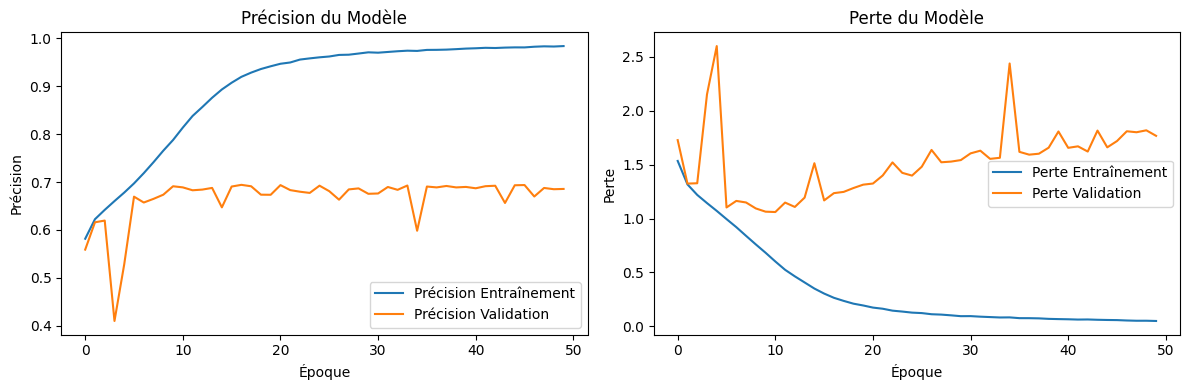

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Précision du Modèle')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.title('Perte du Modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

# **8. Construction du modèle avec BiLSTM --MODELE 1--**

In [13]:
# Définir l'architecture du modèle
input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))  # Image en entrée

# Couches de convolution
x = Conv2D(32, (3, 3), padding="same", activation="relu")(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

# Redimensionner la sortie des convolutions pour l'entrée LSTM
x = Reshape(target_shape=(int(IMG_HEIGHT / 4), int(IMG_WIDTH / 4) * 64))(x)

# Couches BiLSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Décodage final
x = TimeDistributed(Dense(NUM_CLASSES, activation="softmax"))(x)

# Définir le modèle
model = Model(inputs=input_img, outputs=x)

# Compilation du modèle
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 8, 256)              │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 74)               │          19,018 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,267,082 (8.65 MB)

 Trainable params: 2,267,082 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

# **9. Entraînement du modèle --MODELE 1--**

In [14]:
# Callbacks pour l'entraînement
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    x_train, y_train_processed,
    validation_data=(x_test, y_test_processed),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint]
)


2024-12-09 14:36:30.880905: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 284491776 exceeds 10% of free system memory.
2024-12-09 14:36:31.223998: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 284491776 exceeds 10% of free system memory.


Epoch 1/100
540/543 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0770 - loss: 1.5408
Epoch 1: val_loss improved from inf to 1.29495, saving model to best_model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.0771 - loss: 1.5401 - val_accuracy: 0.1161 - val_loss: 1.2949
Epoch 2/100
541/543 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1306 - loss: 1.2584
Epoch 2: val_loss improved from 1.29495 to 1.11870, saving model to best_model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1306 - loss: 1.2581 - val_accuracy: 0.1579 - val_loss: 1.1187
Epoch 3/100
541/543 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1782 - loss: 1.0696
Epoch 3: val_loss improved from 1.11870 to 1.00132, saving model to best_model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1783 - loss: 1.0695 - val_accuracy: 0.1919 - val_loss: 1.0013
Epoch 4/100
542/543 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2105 - loss: 0.9477
Epoch 4: val_loss improved from 1.00132 to

# **10. Visualisation des Performances du --MODELE 1-- : Précision et Perte**

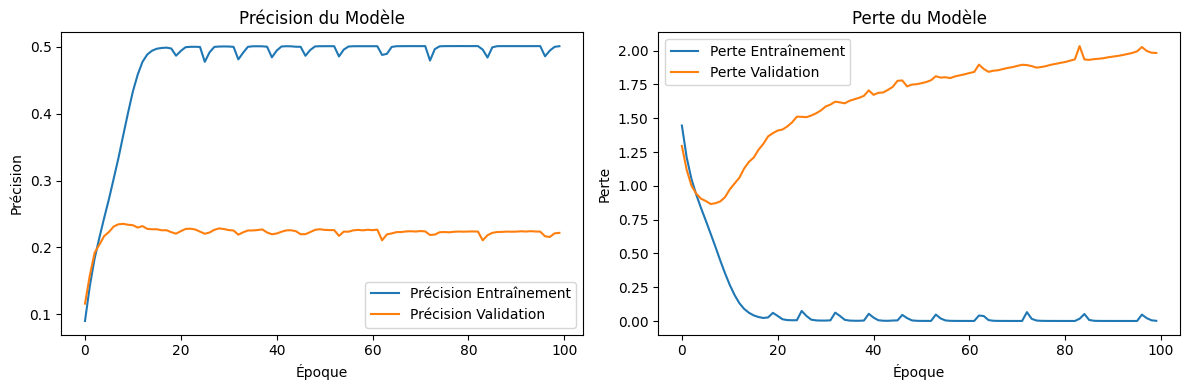

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Précision du Modèle')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.title('Perte du Modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

# **11. Évaluation du --MODELE 1--**

In [16]:
# Évaluation sur les données de test
score = model.evaluate(x_test, y_test_processed, verbose=1)
print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2263 - loss: 2.0091
Test Loss: 1.9829449653625488, Test Accuracy: 0.22184477746486664


# **12. Utilisation du modèle --MODELE 2-- pour l'inférence**

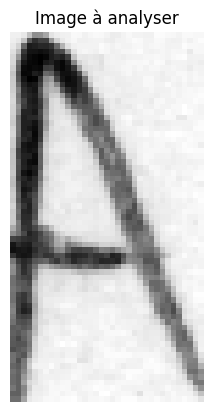

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Texte reconnu: A


In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def infer(model, image_path):
    """Reconnaître le texte dans une image et afficher l'image."""
    # Lire et afficher l'image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Désactive les axes
    plt.title("Image à analyser")
    plt.show()

    # Prétraitement de l'image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Ajouter la dimension batch

    # Prédiction
    preds = model.predict(img)

    # Conversion de la sortie en texte
    pred_text = ""
    for pred in preds[0]:
        char_idx = np.argmax(pred)
        if char_idx != 0:  # Ignorez le padding
            pred_text += CHARACTERS[char_idx]

    print("Texte reconnu:", pred_text)

# Exemple d'inférence avec l'affichage de l'image
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-000x/a01-000x-00-00.png')

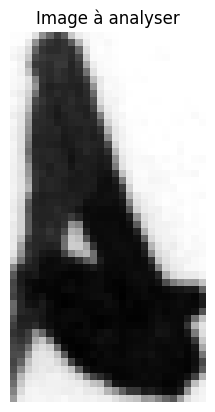

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Texte reconnu: A


In [21]:
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-000u/a01-000u-00-00.png')

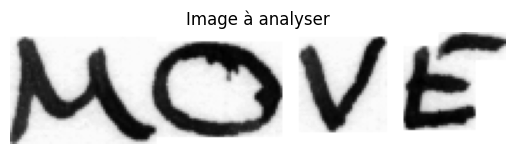

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Texte reconnu: MOVE


In [25]:
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-000u/a01-000u-00-01.png')

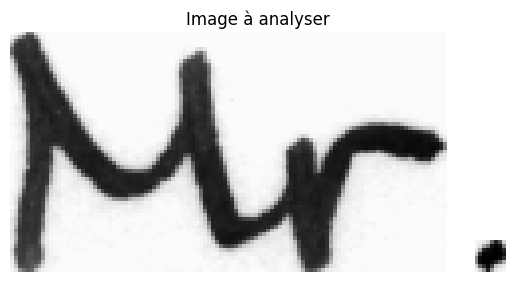

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Texte reconnu: Mr.


In [27]:
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-000u/a01-000u-00-04.png')

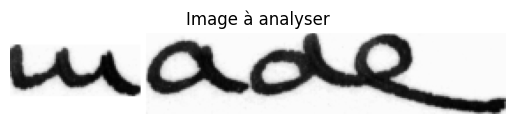

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Texte reconnu: made


In [28]:
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-000u/a01-000u-02-03.png')

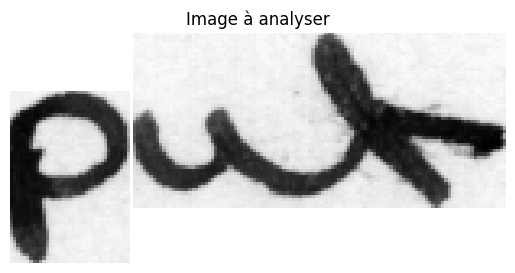

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Texte reconnu: put


In [30]:
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-000u/a01-000u-04-00.png')

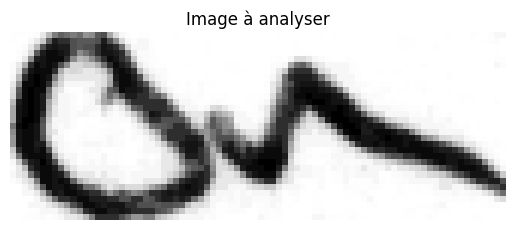

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Texte reconnu: on


In [32]:
infer(model, '/content/Datasets/IAM_Words/words/b03/b03-025/b03-025-00-02.png')

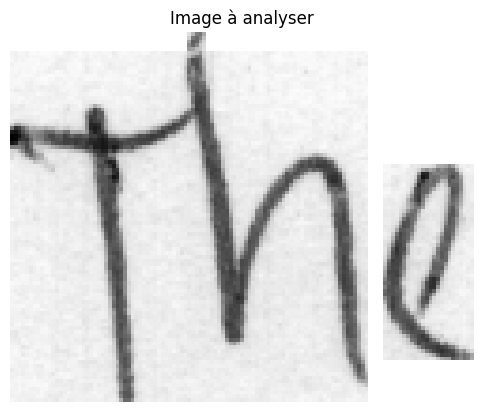

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Texte reconnu: the


In [39]:
infer(model, '/content/Datasets/IAM_Words/words/c03/c03-000a/c03-000a-00-00.png')

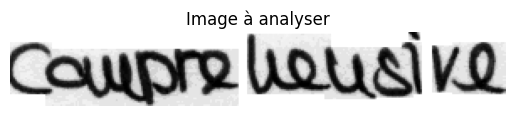

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Texte reconnu: aorrreei


In [38]:
infer(model, '/content/Datasets/IAM_Words/words/b03/b03-092/b03-092-00-00.png')

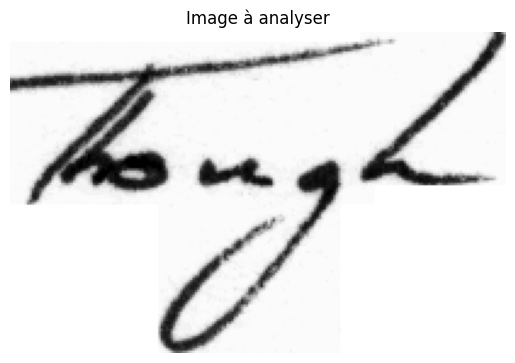

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Texte reconnu: Seyl


In [20]:
infer(model, '/content/Datasets/IAM_Words/words/a01/a01-003/a01-003-00-00.png')